# MP6: AutoVC

Written: Mahir Morshed, 2021

Revised: Mark Hasegawa-Johnson, 2023

Code implementation: Neng Ji, 2023

We will construct neural network layers using PyTorch for use with the system described in ["AUTOVC: Zero-Shot Voice Style Transfer with Only Autoencoder Loss"](https://arxiv.org/abs/1905.05879) (ICML 2019) by Qian, Zhang, Chang, Yang, and Hasegawa-Johnson. 

In [1]:
import numpy as np

import matplotlib.figure
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(417)
np.random.seed(417)

In [2]:
import importlib
import submitted
importlib.reload(submitted)

<module 'submitted' from '/Users/jhasegaw/Dropbox/mark/teaching/ece417/ece417labs/23fall/mp6/src/submitted.py'>

## AutoVC Purpose: Autoencoder-based Voice Conversion

AutoVC, put very simply, is a zero-shot style transfer autoencoder for voice conversion.

(There's a lot to unpack in that sentence, so read on...)

### "style transfer"

The primary assumption that AutoVC makes is that any given speech utterance is dependent on two parts, each separately distributed (Sec. 3.1):

1) a content-specific component, corresponding roughly to the information about a sentence that would be captured in a textual transcription, and
2) a speaker-specific component, imparting information about how a given individual vocally produces that sentence.

It is important that an utterance converted to use the speaker-specific information of a target speaker sound as much like that target speaker as possible, while maintaining constant content-specific information (Eq. 2). For this to be achieved, therefore, it must be possible to disentangle both of these components readily.

### "autoencoder"

An autoencoder (Fig. 1) is a combination of an encoder network and a decoder network, the output of the former serving as the input of the latter. It is often used to learn a lower-dimensional representation or 'embedding' of a given piece of data; because some information is lost in this dimension reduction, the reduction may be considered an information 'bottleneck'. An autoencoder is often trained to approximate its input as closely as possible, improving the quality of the embedding in the process.

AutoVC's encoder attempts to output an embedding for the content-specific component of an utterance by one speaker. This output, together with a similarly produced speaker-specific embedding from an utterance by another speaker, are then fed into AutoVC's decoder to yield a converted utterance. It is the size of the bottleneck (Sec. 3.3) that is tuned to ensure that the content embedding contains as little residual information about the first speaker as possible.

### "zero-shot"

Most, if not all, prior voice conversion attempts require that the source and the target be known to the system in the training process. AutoVC, however, is able to handle speakers that it did not encounter in training. This ability stems largely from the speaker embedding being more than just a one-hot vector, since there is a separate encoder trained to generate it.

### Trying it yourself

Provided for you are two files, `source_utterance.flac` and `target_utterance.flac`. Once you have completed the main MP, you can try AutoVC out, attempting to convert the voice in the source utterance into the voice in the target utterance, by running `python _main.py` and viewing the file `converted_utterance.flac`. You may also specify the files to use manually (for instance, transferring the voice in `a.wav` into `b.wav` and saving the result in `c.wav`), by running `python _main.py b.wav a.wav c.wav`.

## AutoVC Components: Encoders, Bottleneck, and Decoder

This MP primarily consists of the implementation of different PyTorch modules which are direct re-implementations of four of the AutoVC components shown in the figure below: (a) the content encoder, (b) the style encoder, (c.1) the decoder, and (c.2) the postnet. Most of the code you *don't* have to write (e.g., the spectrogram inverter) is adapted from [Kaizhi's original code](https://github.com/auspicious3000/AutoVC), as well as [an adjusted version thereof](https://github.com/RF5/simple-autovc), and is available in the file `_main.py`; you will only need to run that file if you want to test the whole voice conversion pipeline, e.g., if you want to try converting your voice to somebody else's.

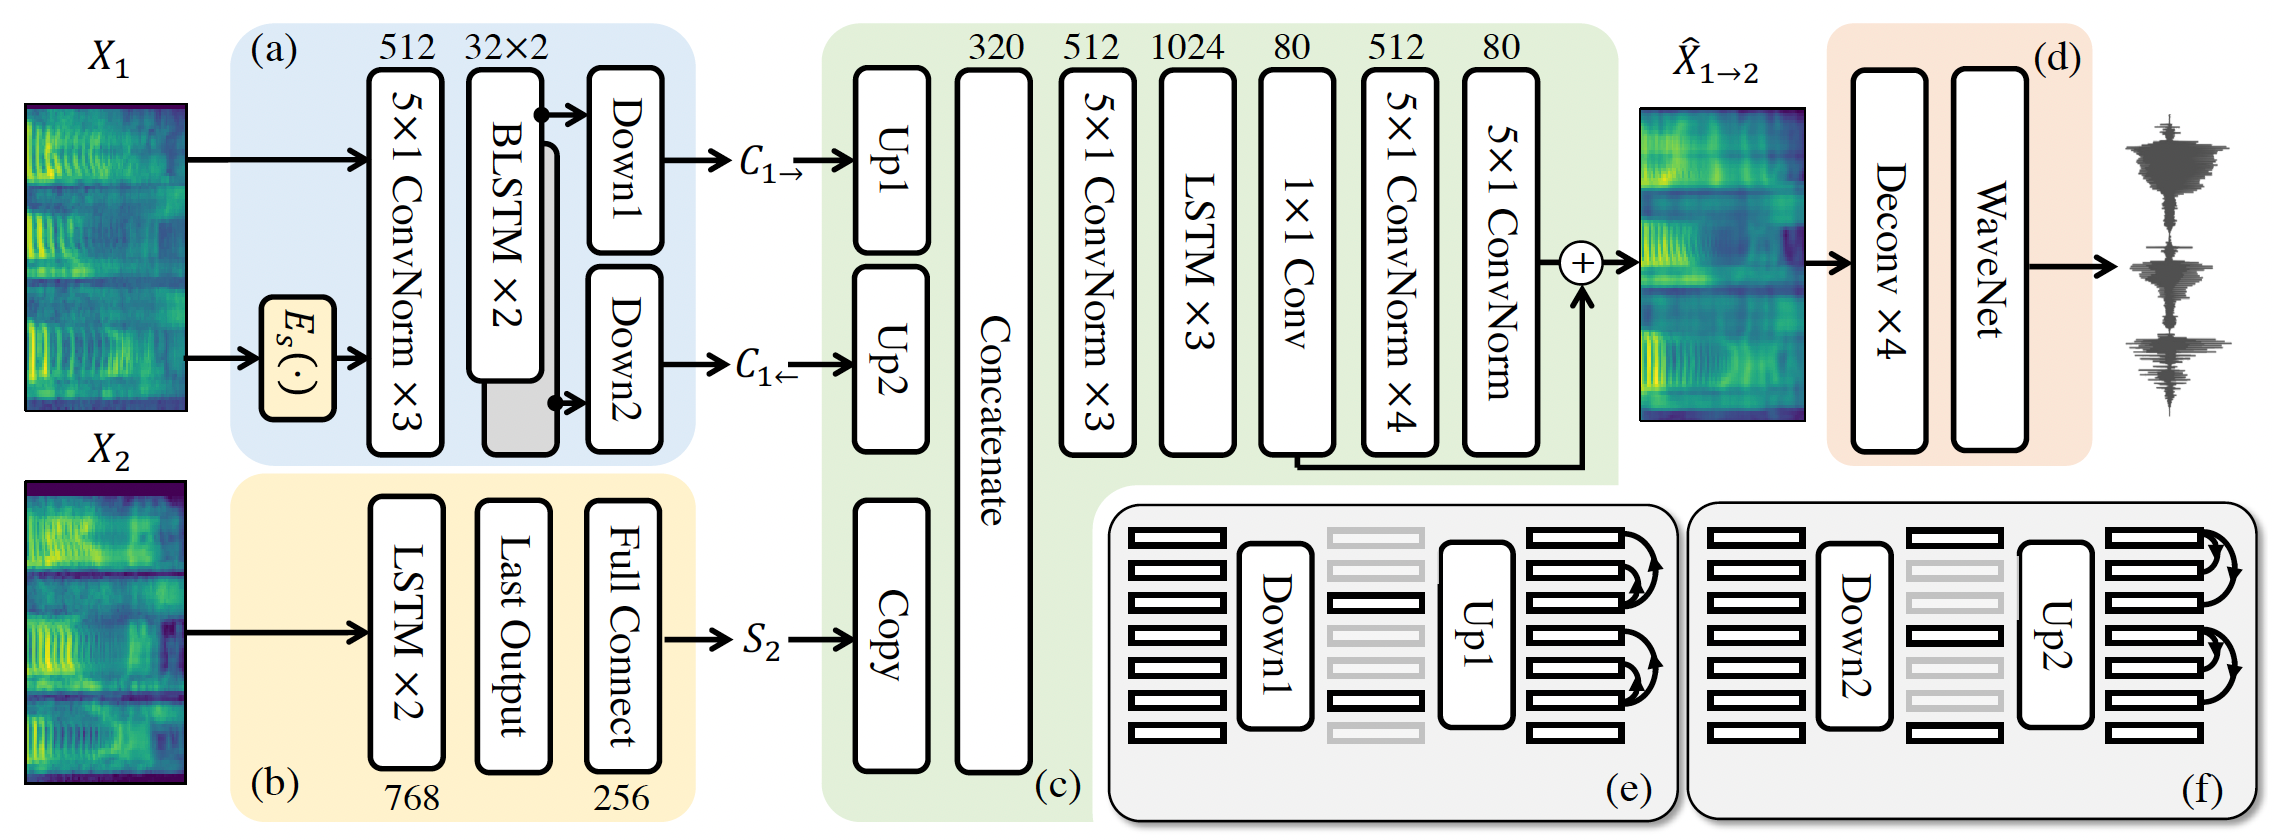
*Figure 3 from Qian et al., 2019.  AUTOVC architecture. The number above each block represents the cell/output dimension of the structure. ConvNorm denotes convolution followed by batch normalization. BLSTM denotes bi-directional LSTM, whose white block denotes forward direction, and grey block denotes backward direction. (a) The content encoder. The $E_s()$ module is of the same architecture as in (b). (b) The style encoder. (c) The decoder. (d) The spectrogram inverter. (e) and (f) demonstrate the downsampling and upsampling of the forward and
backward outputs of the Bi-directional LSTM, using a up/downsampling factor of 3 as an example. The real up/downsampling factor is 32. The lightened feature denotes that they are removed; the arrows denote copying the feature at the arrow origin to the destination.*



The key idea of AutoVC is the **information bottleneck**.  An **information bottleneck** is a general idea in autoencoder architectures: the bottleneck layer is the layer with the fewest nodes, where the information from the input signals is compressed as far as it can be compressed, before it must be expanded to reconstruct the original signal.

In AutoVC, the bottleneck layer is two sequences: 

1. $[C_{1\rightarrow},C_{1\leftarrow}]$ is called the content code.  This is actually a sequence of vectors, each of dimension `dim_neck`, each occurring once every `1/downsample` frames.  
1. $S_2$ is called the style code or speaker code.  This is just one vector per waveform, encoding the speaker identity into a single summary vector.

During training, the content and style codes come from the same waveform.  During testing, however, they come from different waveforms: the style code is supposed to encode the information that would be useful for speaker verification, and the content code encodes everything else.  Here, *everything else* means the text of the utterance, and information about the rhythm and the emphasis that is applied to that text.  

In order to train effectively, the content code needs to be a of a relatively low dimension.  If its dimension is too wide, then the content code will include some information about the speaker ID, and voice conversion will fail.  If its dimension is too narrow, then the content code will not be large enough to encode all of the text of the utterance, so the converted utterance will not be intelligible.  Balancing between the two extremes is done in two ways: (1) by choosing an appropriate value of `dim_neck`, and (2) by downsampling at the encoder, then upsampling again at the decoder, as shown in subfigures (e) and (f) of the figure above.  The problem of correctly balancing between *too wide* and *too narrow* is schematized in the following figure from the paper by Qian et al.:

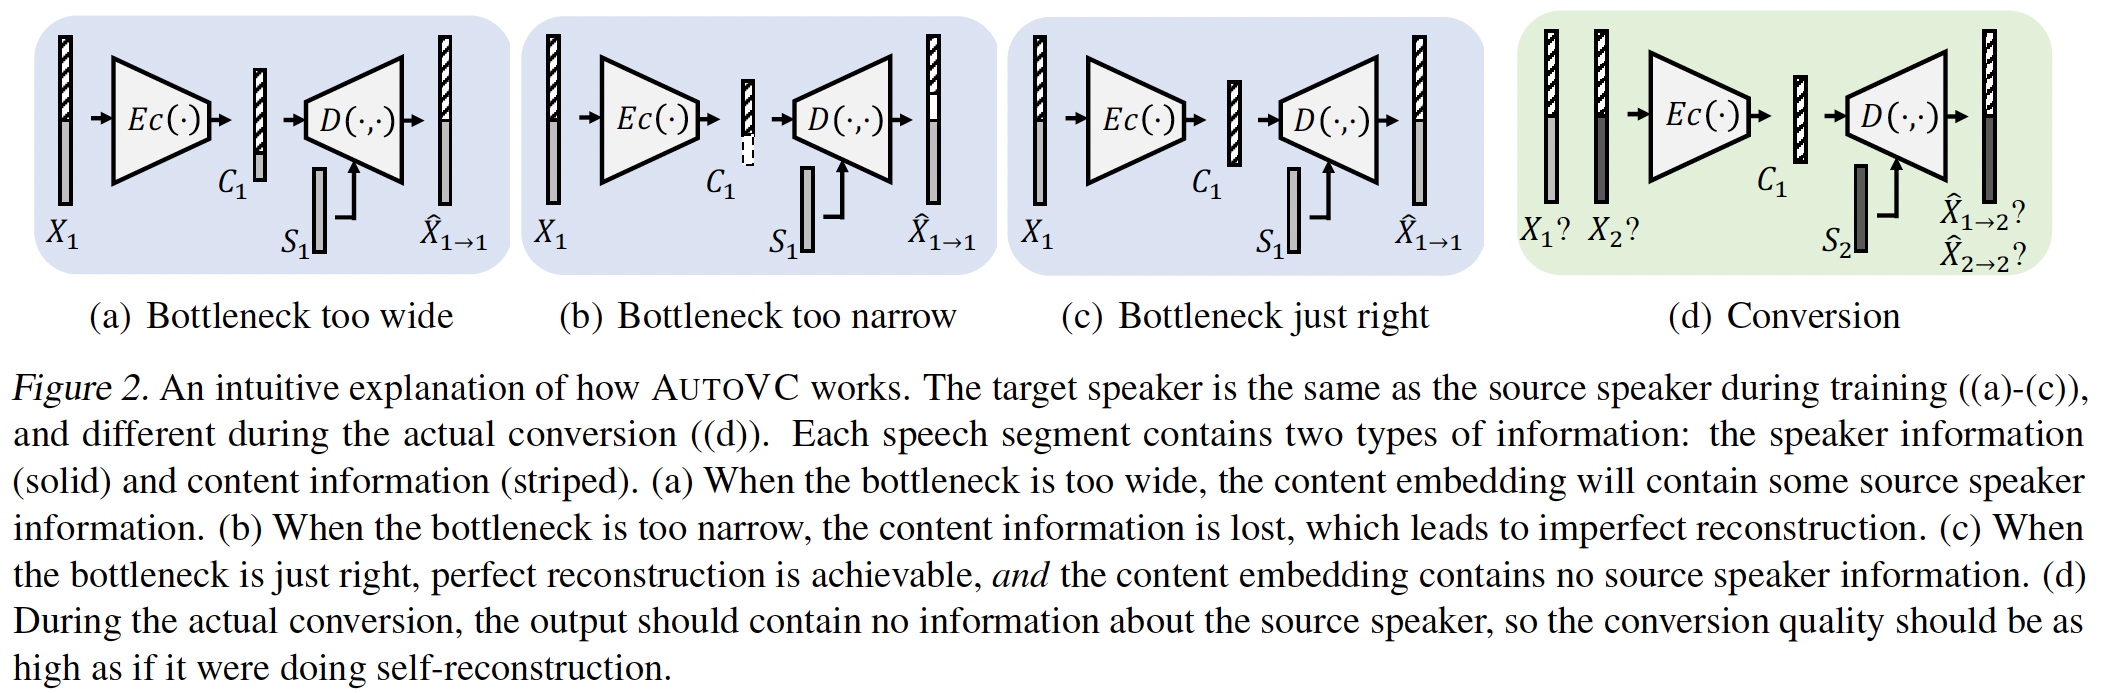

In this MP, we will implement everything except the downsampling and upsampling operations shown in figures (e)-(f).  In other words, we will implement an LSTM that has an output dimension of `dim_neck`, but we will not downsample it, so the frame rate of $C_{1\rightarrow}$ and $C_{1\leftarrow}$ will be the same as the frame rate of the spectrogram.

## How `submitted.py` is structured

Each function to write has type hints in its signature for both inputs and output. In the line `def f(x: int, y: float) -> str:`, `x` is an integer, `y` is a floating-point number, and the output from calling `f(x,y)` is a string.

The hints used for individual tensors are supplied by the [`torchtyping` package](https://github.com/patrick-kidger/torchtyping), which can make PyTorch code you write somewhat easier to understand since it allows you to specify information about dimensions. Here's a brief summary of what you will encounter in the hints:

* Each hint is of the form `TensorType[ ... ]`, where `...` is a comma-separated list of dimensions. Note that these names are not exposed to you in the function itself, so you will still need to extract them from the inputs.
* For each dimension list, an arbitrary string is mapped to a single dimension, and later occurrences of that string are mapped to that same dimension. For example, the function `def f(x: TensorType["batch", "length"]) -> TensorType["length", "batch"]:` takes tensors of two dimensions as input and outputs tensors of a shape transposed from that of the input.

## 1. AutoVC's Content encoder

The first of the AutoVC modules you will be implementing is the content encoder (Fig. 3(a)), appropriately named `Encoder`.

Note that you do not need to handle the concatenation of speaker embedding and spectrogram at the beginning, nor the dimensionality reduction at the end, as these are performed for you in `_main.py`.

In [3]:
import submitted, importlib
importlib.reload(submitted)
help(submitted.Encoder.__init__)
help(submitted.Encoder.forward)

Help on function __init__ in module submitted:

__init__(self, dim_neck: int, dim_emb: int, freq: int)
    Sets up the following:
        self.convolutions - the 1-D convolution layers.
            The first should have 80 + dim_emb input channels and 512 output channels,
                while each following convolution layer should have 512 input and 512 output channels.
                All such layers should have a length-5 kernel, with a stride of 1,
                a dilation of 1, and a padding of 2.
            The output of each convolution layer should be fed into a BatchNorm1d layer of 512 input features,
            and the output of each BatchNorm1d should be fed into a ReLU layer.
        self.recurrents - a bidirectional LSTM with two layers, an input size of 512,
            and an output size of dim_neck.

Help on function forward in module submitted:

forward(self, x: typing.Annotated[torch.Tensor, {'__torchtyping__': True, 'details': ('batch', 'input_dim', 'length',), 

Note that this encoder network makes use of a number of pytorch modules, including:

* [Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)
* (optional) [ModuleList](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html)
* [Conv1d](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html)
* [BatchNorm1d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)
* [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
* (optional) [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)
* [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)

## 2. AutoVC's Style Encoder

The second module you will implement is a speaker embedding encoder, appropriately named `SpeakerEmbedderGeeArrYou`. This is not exactly the same such encoder used in the original AutoVC, but is simplified somewhat by the use of GRUs.

In [7]:
importlib.reload(submitted)
help(submitted.SpeakerEmbedderGeeArrYou.__init__)
help(submitted.SpeakerEmbedderGeeArrYou.forward)

Help on function __init__ in module submitted:

__init__(self, n_hid: int, n_mels: int, n_layers: int, fc_dim: int, hidden_p: float) -> None
    Sets up the following:
        self.rnn_stack - an n_layers-layer GRU with n_mels input features,
            n_hid hidden features, and a dropout of hidden_p.
        self.projection - a Linear layer with an input size of n_hid
            and an output size of fc_dim.

Help on function forward in module submitted:

forward(self, x: typing.Annotated[torch.Tensor, {'__torchtyping__': True, 'details': ('batch', 'frames', 'n_mels',), 'cls_name': 'TensorType'}]) -> typing.Annotated[torch.Tensor, {'__torchtyping__': True, 'details': ('batch', 'fc_dim',), 'cls_name': 'TensorType'}]
    Performs the forward propagation of the SpeakerEmbedderGeeArrYou.
        After passing the input through the RNN, the last frame of the output
        should be taken and passed through the fully connected layer.
        Each of the frames should then be normalized 

In addition to the modules used by the content encoder, this network also uses the following modules:

* [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html)
* [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)

## 3. AutoVC's decoder

The third of the AutoVC modules you will be implementing is the decoder, which is the portion of Figure (3c) up to and including the $1\times 1$-conv.  A $1\times 1$ convolution is nothing more or less than a fully-connected linear projection layer, applied separately at every time step in the input, so we will use the term `self.fc_projection` to mean the $1\times 1$-conv layer in Figure (3).  In `submitted.py`, the decoder network is called `Decoder`.

In [8]:
importlib.reload(submitted)
help(submitted.Decoder.__init__)
help(submitted.Decoder.forward)

Help on function __init__ in module submitted:

__init__(self, dim_neck: int, dim_emb: int, dim_pre: int) -> None
    Sets up the following:
        self.recurrent1 - a unidirectional LSTM with one layer, an input size of 2*dim_neck + dim_emb
            and an output size of dim_pre.
        self.convolutions - the 1-D convolution layers.
            Each convolution layer should have dim_pre input and dim_pre output channels.
            All such layers should have a length-5 kernel, with a stride of 1,
            a dilation of 1, and a padding of 2.
            The output of each convolution layer should be fed into a BatchNorm1d layer of dim_pre input features,
            and the output of that BatchNorm1d should be fed into a ReLU.
        self.recurrent2 - a unidirectional LSTM with two layers, an input size of dim_pre
            and an output size of 1024.
        self.fc_projection = a Linear layer with an input size of 1024 and an output size of 80.

Help on function forwar

## 4. AutoVC's decoder post-network

The last of the AutoVC modules you will be implementing is the decoder post-network, which is the final Conv1d layers in Fig. 3(c).  As shown in Fig. 3(c), we will use five $5\times 1$ ConvNorm layers, with 512-dimensional hidden vectors, and an 80-dimensional output vector on the last layer.  In `submitted.py`, this network is called `Postnet`.

In [10]:
importlib.reload(submitted)
help(submitted.Postnet.__init__)
help(submitted.Postnet.forward)

Help on function __init__ in module submitted:

__init__(self) -> None
    Sets up the following:
        self.convolutions - a Sequential object with five Conv1d layers, each with length-5 kernels,
        a stride of 1, a padding of 2, and a dilation of 1:
            The first should take an 80-channel input and yield a 512-channel output.
            The next three should take 512-channel inputs and yield 512-channel outputs.
            The last should take a 512-channel input and yield an 80-channel output.
            Each layer's output should be passed into a BatchNorm1d,
            and (except for the last layer) from there through a Tanh,
            before being sent to the next layer.

Help on function forward in module submitted:

forward(self, x: typing.Annotated[torch.Tensor, {'__torchtyping__': True, 'details': ('batch', 'input_channels', 'n_mels',), 'cls_name': 'TensorType'}]) -> typing.Annotated[torch.Tensor, {'__torchtyping__': True, 'details': ('batch', 'input_cha

## Testing your code

 You can test them by running python _main.py and viewing the file converted_utterance.flac